In [1]:
import math
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import pandas as pd
import seaborn as sns
from doe_xstock.database import SQLiteDatabase
from doe_xstock.utilities import split_lines

In [2]:
database_filepath = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/database.db'
figures_directory = 'figures/'
schedule_data_directory = '../schedule_data'
database = SQLiteDatabase(database_filepath)

# Understanding the Metadata
***

In [51]:
# # numeric metadata
metadata = database.get_table('metadata')
columns_to_exclude = ['id', 'bldg_id', 'dataset_id','upgrade','metadata_index','in_county','in_puma','in_ashrae_iecc_climate_zone_2004', 'in_building_america_climate_zone', 'in_iso_rto_region', 'applicability', 'in_ahs_region', 'in_applicable','in_cec_climate_zone','in_census_division','in_census_division_recs','in_census_region','in_geometry_building_type_acs','in_geometry_building_type_height','in_geometry_building_type_recs','in_state','in_weather_file_longitude','in_weather_file_latitude','in_weather_file_city','in_nhgis_county_gisjoin','in_state_name','in_american_housing_survey_region','in_weather_file_2018','in_weather_file_tmy3','in_resstock_county_id','in_vacancy_status']
columns = [c for c in metadata.columns if c not in columns_to_exclude and pd.api.types.is_numeric_dtype(metadata[c])]
column_count = 6
row_count = math.ceil(len(columns)/column_count)
fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count,3*row_count))

for ax, column in zip(fig.axes, columns):
    ax.hist(metadata[column])
    ax.set_title(split_lines(column, line_character_limit=28,delimiter='_'))

plt.tight_layout()
plt.savefig(os.path.join(figures_directory,'travis_county_numeric_metadata_histogram.pdf'),transparent=True, bbox_inches='tight')
plt.close()

# non numeric metadata
columns = [c for c in metadata.columns if c not in columns_to_exclude and not pd.api.types.is_numeric_dtype(metadata[c])]
column_count = 4
row_count = math.ceil(len(columns)/column_count)
fig, axs = plt.subplots(row_count, column_count, figsize=(7*column_count,6*row_count))

for ax, column in zip(fig.axes, columns):
    plot_data = metadata.groupby(column).size().reset_index(name='count')
    x, y = list(range(plot_data.shape[0])), plot_data['count']
    ax.barh(x,y)
    ax.set_yticks(x)
    ax.set_yticklabels(plot_data[column].to_list())
    ax.set_title(split_lines(column, line_character_limit=28,delimiter='_'))

plt.tight_layout()
plt.savefig(os.path.join(figures_directory,'travis_county_non_numeric_metadata_histogram.pdf'),transparent=True, bbox_inches='tight')
plt.close()

In [3]:
# schedules
schedule_columns = database.query_table("""PRAGMA table_info(schedule)""")
schedule_columns = schedule_columns[~schedule_columns['name'].isin(['metadata_id','timestep'])]['name'].tolist()

for i, column in enumerate(schedule_columns):
    print(f'\r{i+1}/{len(schedule_columns)}',end='')
    database.query_table(f"""
    SELECT
        metadata_id,
        day*24 + hour AS timestep,
        day,
        hour,
        AVG({column}) AS {column}
    FROM (
        SELECT
            metadata_id,
            CAST((timestep - CAST(timestep/96 AS INTEGER)*96)/4 AS INTEGER) AS hour,
            CAST(timestep/96 AS INTEGER) AS day,
            {column}
        FROM schedule
    ) t
    GROUP BY
        metadata_id,
        day,
        hour
    """).to_pickle(os.path.join(schedule_data_directory,f'{column}.pkl'))

24/24

In [ ]:
plot_data = database.query_table(f"""
SELECT
    metadata_id,
    day*24 + hour AS timestep,
    day,
    hour,
    AVG(value) AS value
FROM (
    SELECT
        metadata_id,
        CAST((timestep - CAST(timestep/96 AS INTEGER)*96)/4 AS INTEGER) AS hour,
        CAST(timestep/96 AS INTEGER) AS day,
        {column} AS value
    FROM schedule
) t
GROUP BY
    metadata_id,
    day,
    hour
""")

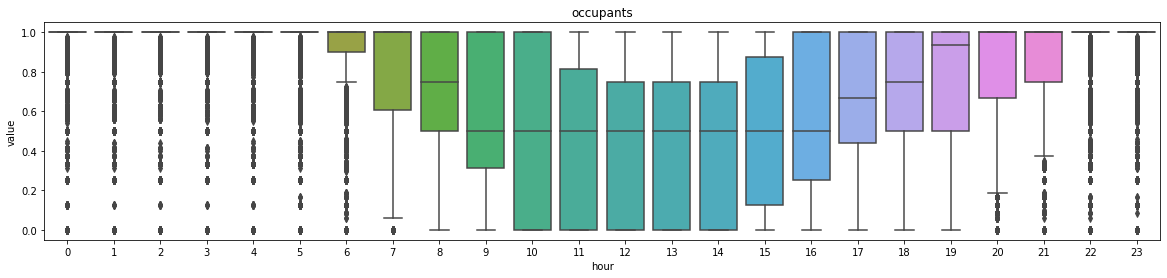

In [12]:
# plot_data = schedule.copy()
fig, ax = plt.subplots(1,1,figsize=(20,4))
sns.boxplot(x='hour',y='value',data=plot_data,ax=ax)
ax.set_title(column)
plt.show()

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import pandas as pd
from saxpy.alphabet import cuts_for_asize
from saxpy.paa import paa
from saxpy.sax import ts_to_string
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
DATABASE_FILEPATH = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/database.db'
FIGURES_DIRECTORY = 'figures/'
SCHEDULE_DATA_DIRECTORY = '../schedule_data'
SCHEDULE_PCA_DATA_DIRECTORY = '../schedule_pca_data'
SCHEDULE_DATA_FILEPATHS = [os.path.join(SCHEDULE_DATA_DIRECTORY,f) for f in os.listdir(SCHEDULE_DATA_DIRECTORY) if f.endswith('.pkl')]
SCHEDULE_DATA_FILEPATHS = sorted(SCHEDULE_DATA_FILEPATHS)
SEASONS = {
    1:'winter',2:'winter',12:'winter',
    3:'spring',4:'spring',5:'spring',
    6:'summer',7:'summer',8:'summer',
    9:'fall',10:'fall',11:'fall',
}
PCA_CUMMULATIVE_VARIANCE_THRESHOLD = 0.9
SAX_A = 4
SAX_W_MAX = 8
DATE_RANGE = pd.DataFrame({'timestamp':pd.date_range('2017-01-01','2017-12-31 23:00:00', freq='H')})
DATE_RANGE['timestep'] = DATE_RANGE.index
DATE_RANGE['month'] = DATE_RANGE['timestamp'].dt.month
DATE_RANGE['week'] = DATE_RANGE['timestamp'].dt.isocalendar().week
DATE_RANGE['date'] = DATE_RANGE['timestamp'].dt.normalize()
DATE_RANGE['day_of_week'] = DATE_RANGE['timestamp'].dt.weekday
DATE_RANGE.loc[DATE_RANGE['day_of_week'] == 6, 'week_of'] = DATE_RANGE.loc[DATE_RANGE['day_of_week'] == 6]['timestamp'].dt.normalize()
DATE_RANGE['week_of'] = DATE_RANGE['week_of'].ffill()
DATE_RANGE['season'] = DATE_RANGE['month'].map(lambda x: SEASONS[x])
# lambda functions
schedule_name = lambda x: x.split('/')[-1].split('.')[0]
threshold_satisfaction_index = lambda x: [
    i for i, v in enumerate([sum(x[0:i + 1]) for i in range(len(x))]) if v >= PCA_CUMMULATIVE_VARIANCE_THRESHOLD
][0]
data_list = []

# start here
for i, filepath in enumerate(SCHEDULE_DATA_FILEPATHS):
    print(f'\r{i+1}/{len(SCHEDULE_DATA_FILEPATHS)}',end='')
    plot_data = pd.read_pickle(filepath)
    column = schedule_name(filepath)
    plot_data = plot_data.rename(columns={column:'value'})
    plot_data['column'] = column
    data_list.append(plot_data)

plot_data = pd.concat(data_list,ignore_index=True)
data_list = None
columns = plot_data['column'].unique()
plot_data = plot_data.pivot(index=['metadata_id','timestep','day','hour'],columns='column',values='value')

24/24

In [ ]:
scaler = StandardScaler()
x = plot_data[]